In [232]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import model as m
import plot
import predict

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load experiment

In [242]:
e = exp.load('iter_exps03', experiment_location='experiments', datadir='Mdata')
e.trials_df

,trial_idx,model_name,expt,name,trial,mean_LLs
0,0,TconvScaffoldIter,expt04,TconvScaffoldIter0,<experiment.Trial object at 0x7f9825890f40>,0.440576
0,1,TconvScaffoldIter,expt04,TconvScaffoldIter1,<experiment.Trial object at 0x7f98258ad490>,0.452279
0,2,TconvScaffoldIter,expt04,TconvScaffoldIter2,<experiment.Trial object at 0x7f9825843520>,0.414019
0,3,TconvScaffoldIter,expt04,TconvScaffoldIter3,<experiment.Trial object at 0x7f9825749df0>,0.401740
0,4,TconvScaffoldIter,expt04,TconvScaffoldIter4,<experiment.Trial object at 0x7f98258ad910>,0.436305
0,5,TconvScaffoldIter,expt04,TconvScaffoldIter5,<experiment.Trial object at 0x7f9825abfd00>,0.436308


In [255]:
e.trials[4].model.print_params('reg_vals')

core
0 {'d2xt': 0.0001, 'center': 0.0, 'bcs': {'d2xt': 1}}
1 {'activity': 0.0, 'd2xt': 0.0001, 'center': 0.0, 'bcs': {'d2xt': 1}}
readout
0 None


# analysis

In [240]:
# sort the trials into models with the same parameters
models = {}
for trial in e.trials:
    num_filters = '.'.join([str(trial.model.networks[0].layers[0].params['num_filters']),
                            str(trial.model.networks[0].layers[1].params['num_filters'])])
    filter_widths = '.'.join([str(trial.model.networks[0].layers[0].params['filter_width']),
                              str(trial.model.networks[0].layers[1].params['filter_width'])])
    iter_filter_height = trial.model.networks[0].layers[1].params['num_lags']
    num_iter = trial.model.networks[0].layers[1].params['num_iter']
    if (num_filters, filter_widths, iter_filter_height, num_iter) in models:
        models[(num_filters, filter_widths, iter_filter_height, num_iter)].append(trial)
    else:
        models[(num_filters, filter_widths, iter_filter_height, num_iter)] = [trial]

models.keys()

dict_keys([('8.8', '17.7', 3, 3), ('12.12', '17.7', 3, 3)])

In [241]:
# get the best models by LL
best_models = {}
for k,v in models.items():
    best_models[k] = sorted(v, key=lambda x: np.mean(x.LLs), reverse=True)[0]
# print the params and mean LLs
for k,v in best_models.items():
    print(k, np.mean(v.LLs))

('8.8', '17.7', 3, 3) 0.44057578
('12.12', '17.7', 3, 3) 0.4522793


In [207]:
# get experiment boundaries (they all use the same dataset)
dataset = e.trials[0].dataset
expt_boundaries = np.cumsum(dataset.num_units)
expt_boundaries

lazy loading dataset
Loading ['expt04', 'expt06', 'expt07', 'expt09', 'expt11']
Loading expt04
  Time embedding...
  Done.
Loading expt06
  Time embedding...
  Done.
Loading expt07
  Time embedding...
  Done.
Loading expt09
  Time embedding...
  Done.
Loading expt11
  Time embedding...
  Done.


array([ 35,  63,  91, 114, 139])

In [223]:
# get the weights of the readout layer for the best models
# and just get the middle space-time filter
readout_weights = {}
for k,v in best_models.items():
    neurons = []
    for neuron in range(v.model.networks[1].layers[0].weights.shape[2]):
        neurons.append(v.model.networks[1].layers[0].weights[:,:,neuron])
    readout_weights[k] = neurons

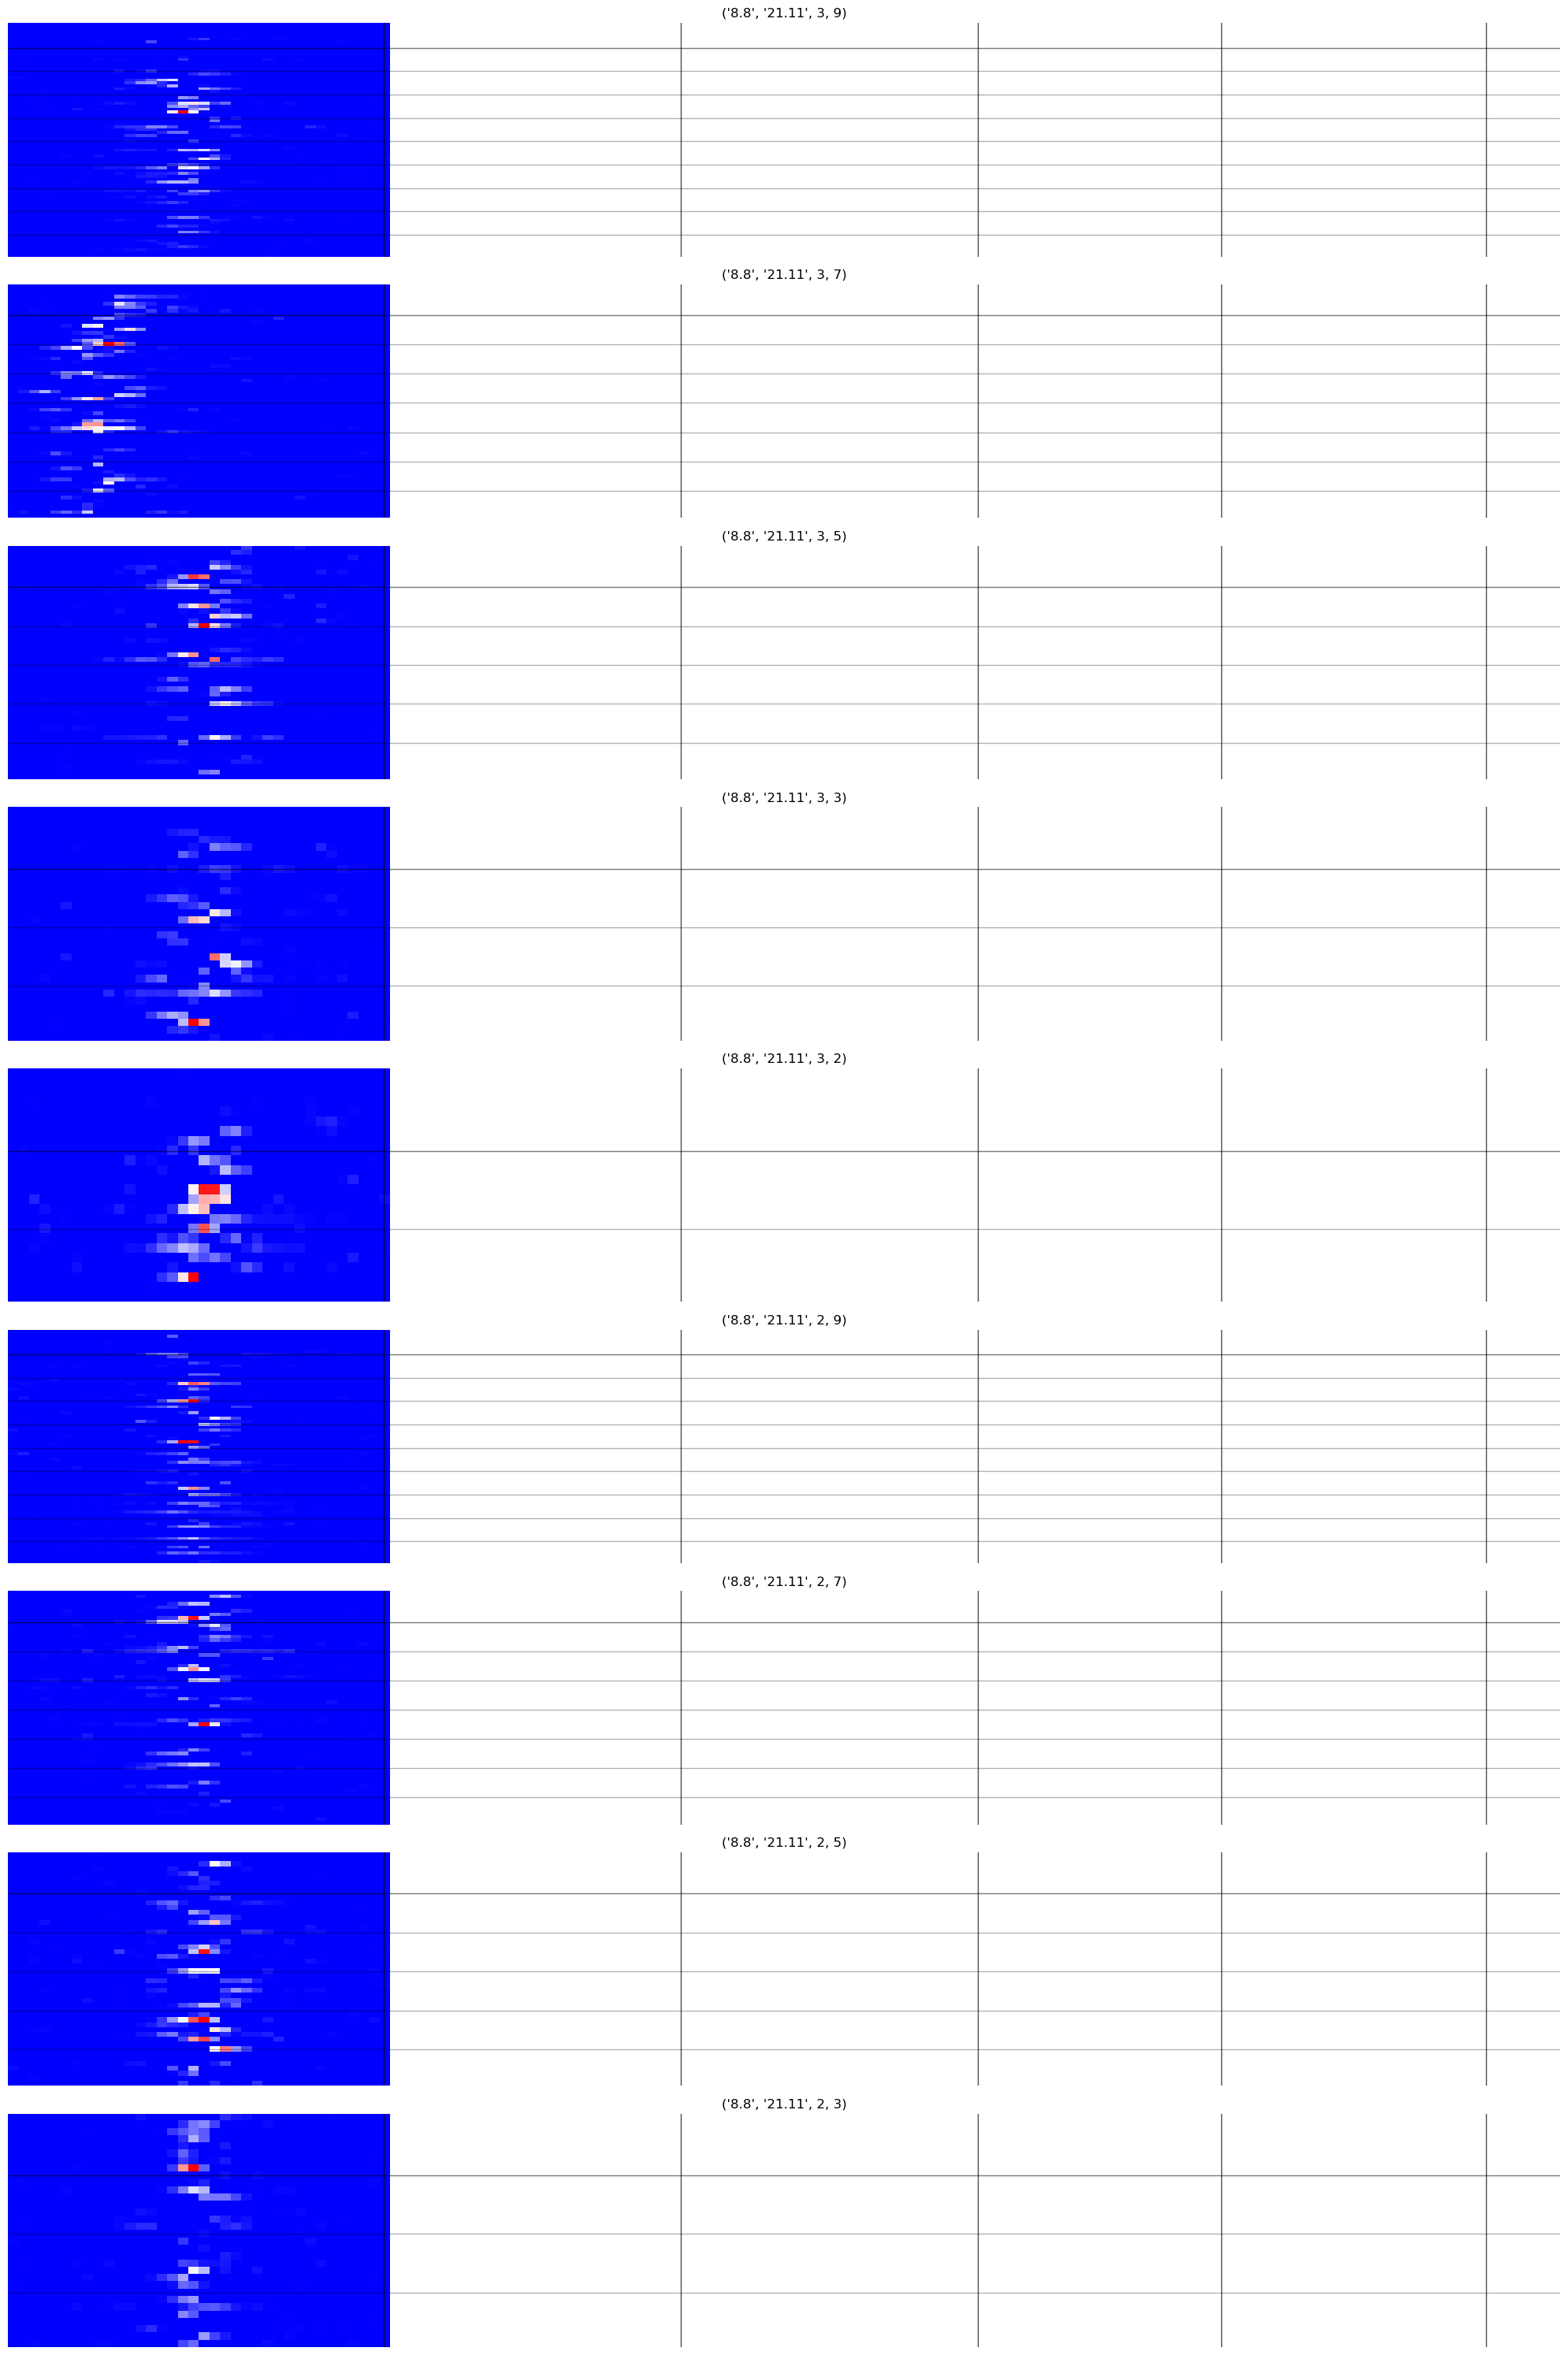

In [224]:
neuron = 0
# plot the readout weights
# color the excitatory weights red and the inhibitory weights blue
fig, axs = plt.subplots(len(readout_weights.keys()),1, figsize=(20,30))
for i,k in enumerate(readout_weights.keys()):
    num_subunits, filter_widths, num_lags, num_iter = k
    ax = axs.flatten()[i]
    ax.imshow(readout_weights[k][neuron], cmap='bwr', origin='upper', aspect='auto')
    ax.set_title(k)
    ax.axis('off')
    
    # put a vertical line between each experiment
    for expt_boundary in expt_boundaries:
        ax.axvline(expt_boundary, color='k', linewidth=1, alpha=0.7)
    
    # put a horizontal line between each layer
    layer_boundaries = [int(num_subunits.split('.')[0])]
    for layer in range(1, num_iter+1):
        layer_boundaries.append(layer*int(num_subunits.split('.')[1]))
    for layer_boundary in layer_boundaries:
        ax.axhline(layer_boundary, color='k', linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

# TODO:
# 1) reshape the weights to be more interpretable
# 2) properly color the excitatory and inhibitory weights
# 3) cluster the weights by neuron and experiment
# 4) plot the weights in a more interpretable way

In [105]:
import pprint

# get the reg_vals for each trial and plot them compare to the LLs
reg_valses = []
LLs = []
for trial in e.trials:
    reg_vals = []
    for network in trial.model.networks:
        for layer in network.layers:
            if 'reg_vals' in layer.params:
                for k,v in layer.params['reg_vals'].items():
                    if k =='bcs':
                        for k2,v2 in v.items():
                            reg_vals.append(v2)
                    else:
                        reg_vals.append(v)
    reg_valses.append(reg_vals)
    LLs.append(np.mean(trial.LLs))

print(reg_valses[0])
#pprint.pprint(LLs)

[array([0.09760542]), array([0.02992758]), 1, array([0.00215319]), array([0.08978188]), array([0.06255312]), 1, array([0.02356874])]


In [89]:
# filter_width=(17,7) num_subunits=(12,12), num_iter=3  
# 17x14 x 12 --> 7x12 x 12 --> 36*12 + 36*12*3

# 21x10 x 10 --> 36x10x3
model = e.trials_where(trial_idx=5)[0].model
model.NDN.list_parameters()
model.networks[0].layers[0].weights.shape, model.networks[1].layers[0].weights.shape

Network 0:
  Layer 0:
      weight: torch.Size([231, 8])
  Layer 1:
      weight: torch.Size([176, 8])
Network 1:
  Layer 0:
      weight: torch.Size([1152, 49])
      bias: torch.Size([49])


((21, 11, 8), (32, 36, 49))

# reweight the subunits

max:  0.17548232 min:  -0.17548232


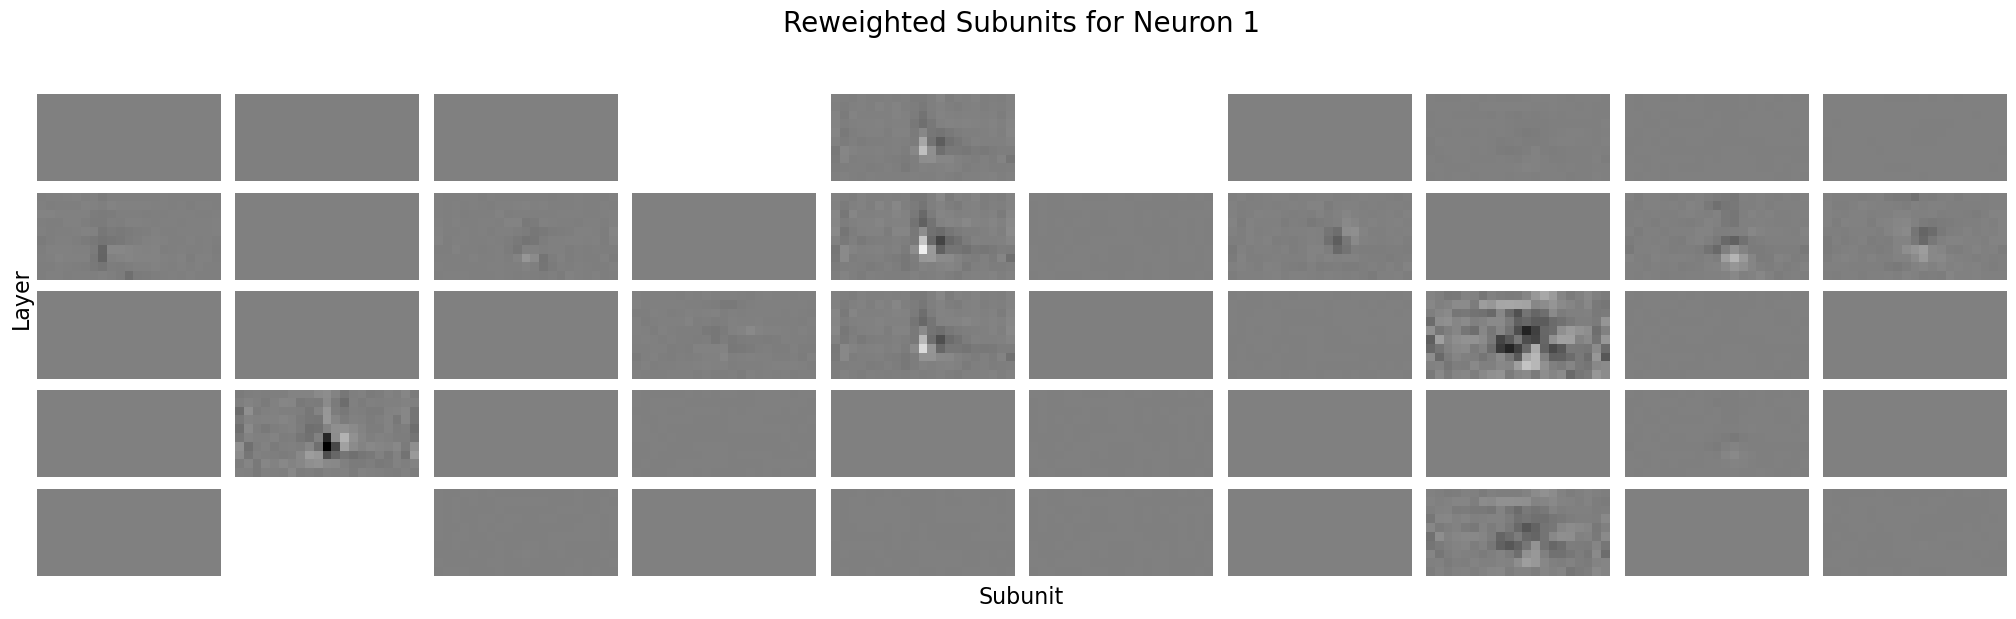

In [107]:
# # reweight the subunits by their connection to the readout layer
# # get the readout layer weights
# readout_weights = model.networks[1].layers[0].weights
# # get the subunit weights
# subunit_weights = model.networks[0].layers[0].weights
# 
# # swap the last and first axes of the subunit weights
# subunit_weights = np.swapaxes(subunit_weights, 0, 2)
# 
# # reweight the subunits
# reweighteds = [] # layer, neuron, subunit
# for neuron in range(11):
#     reweighted_layer = []
#     for layer in range(5):
#         reweighted_neuron = []
#         for i,readout_weight in enumerate(readout_weights[20:30,15,neuron]):
#             reweighted = readout_weight * subunit_weights[i,:,:]
#             reweighted_neuron.append(reweighted)
#         reweighted_layer.append(reweighted_neuron)
#     reweighteds.append(reweighted_layer)
# 
# # get the min and max of the reweighted subunits
# imax = np.max(reweighteds)
# imin = -imax
# print('max: ', imax, 'min: ', imin)
# 
# # plot the reweighted subunits for neuron 1
# fig, axs = plt.subplots(5,10, figsize=(20,6))
# for layer in range(5):
#     for i,reweighted in enumerate(reweighteds[layer][1]):
#         ax = axs[layer,i]
#         ax.imshow(reweighted, cmap='gray', origin='lower', vmin=imin, vmax=imax)
#         ax.axis('off')
# plt.tight_layout()
# plt.suptitle('Reweighted Subunits for Neuron 1', fontsize=20)
# # put spacing between the title and the subplots
# plt.subplots_adjust(top=0.85)
# # label the super axes large font
# fig.text(0.5, 0, 'Subunit', ha='center', va='center', fontsize=16)
# fig.text(0, 0.5, 'Layer', ha='center', va='center', rotation='vertical', fontsize=16)
# plt.show()

# plot the results

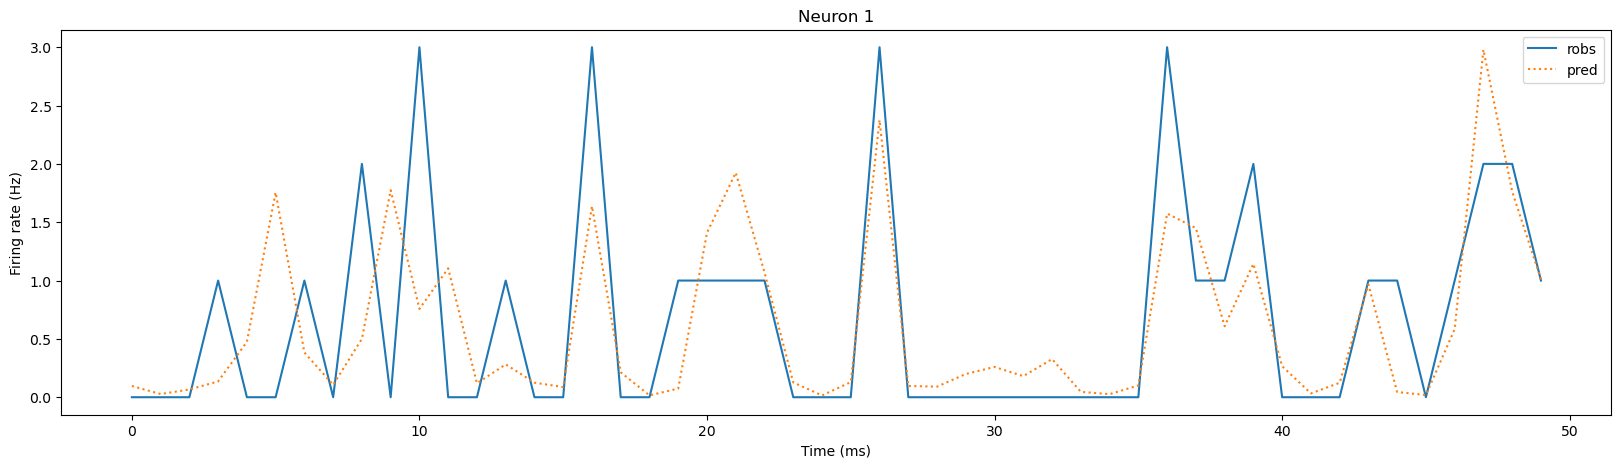

In [92]:
results = predict.predict(e.trials_where(trial_idx=5)[0].model, dataset=e.trials_where(trial_idx=5)[0].dataset[100:150])
plot.plot_robs(results.robs, results.pred, neuron=1, figsize=(20,5))

# explore the Tconv

In [ ]:
# define a model
tconv_layer = m.TemporalConvolutionalLayer(
    num_filters=8,
    num_inh=4,
    filter_dims=[1, 21, 1, 11],
    window='hamming',
    NLtype=m.NL.relu,
    norm_type=m.Norm.unit,
    bias=False,
    initialize_center=True,
    output_norm='batch',
    reg_vals={'d2xt': 0.01, 'center': 0.01, 'bcs': {'d2xt': 1}},
    padding='spatial')

itert_layer = m.IterativeTemporalConvolutionalLayer(
    num_filters=8,
    num_inh=4,
    filter_dims=11,
    num_lags=2,
    window='hamming',
    NLtype=m.NL.relu,
    norm_type=m.Norm.unit,
    bias=False,
    initialize_center=True,
    output_norm='batch',
    num_iter=3,
    output_config='full',
    reg_vals={'activity':0.01, 'd2xt': 0.01, 'center': 0.01, 'bcs': {'d2xt': 1}})

readout_layer = m.Layer(
    pos_constraint=True, # because we have inhibitory subunits on the first layer
    norm_type=m.Norm.none,
    NLtype=m.NL.softplus,
    bias=True,
    initialize_center=True,
    reg_vals={'glocalx': 0.01}
)

inp_stim = m.Input(covariate='stim', input_dims=[1,36,1,14])

core_net = m.Network(layers=[tconv_layer, itert_layer],
                     network_type=m.NetworkType.scaffold,
                     name='core')
readout_net = m.Network(layers=[readout_layer],
                        name='readout')
# this is set as a starting point, but updated on each iteration
output_11 = m.Output(num_neurons=11)

inp_stim.to(core_net)
core_net.to(readout_net)
readout_net.to(output_11)
itert_model = m.Model(output_11, name='tconv_scaffold_iter', create_NDN=False, verbose=True)

# create and run an experiment
experiment = exp.Experiment(name=self.experiment_name,
                            description=self.experiment_desc,
                            generate_trial=lambda prev_trials: self.generate_trial(prev_trials),
                            experiment_location=self.experiment_location,
                            overwrite=self.overwrite_mode)
experiment.run()